In [1]:
import cv2
import math

count = 0
videoFile = "../video/Tom and Jerry.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5)

x=1

while (cap.isOpened()):
    frameId = cap.get(1)
    ret, frame = cap.read()
    
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename = "./picture/frame%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)

cap.release()
print("Done!")

Done!


In [2]:
#Tom and Jerry3.mp4 이미지 추출

count = 0
videoFile = "../video/Tom and Jerry 3.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5)

x=1

while (cap.isOpened()):
    frameId = cap.get(1)
    ret, frame = cap.read()
    
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename = "./picture/test%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)

cap.release()
print("Done!")

Done!


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
from keras.utils import np_utils
from skimage.transform import resize

%matplotlib inline

data = pd.read_csv('../dataset/mapping.csv')
test = pd.read_csv('../dataset/testing.csv')


Using TensorFlow backend.


In [4]:
X = []
for img_name in data.Image_ID:
    img = plt.imread('./picture/' + img_name)
    X.append(img)
    
X = np.array(X)

test_image = []
for img_name in test.Image_ID:
    img = plt.imread('./picture/' + img_name)
    test_image.append(img)     
test_img = np.array(test_image)

In [5]:
from keras.utils import np_utils

train_y = np_utils.to_categorical(data.Class)
test_y = np_utils.to_categorical(test.Class)

In [6]:
image = []
for i in range(0, X.shape[0]):
    a = resize(X[i], preserve_range=True, output_shape=(224, 224, 3)).astype(int)
    image.append(a)  
X = np.array(image)

test_image = []
for i in range(0, test_img.shape[0]):
    a = resize(test_img[i], preserve_range=True, output_shape=(224, 224)).astype(int)
    test_image.append(a)
test_image = np.array(test_image) 

In [7]:
#from keras.applications.vgg16 import preprocess_input
#X = preprocess_input(X)
#test_image = preprocess_input(test_image)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, train_y, test_size=0.3, random_state=42)

In [9]:
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout, Flatten

transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
transfer_model.trainable=False

In [10]:
#X_train = base_model.predict(X_train)
#X_valid = base_model.predict(X_valid)
#test_image = base_model.predict(test_image)

In [11]:
#X_train = X_train.reshape(208, 7*7*512)
#X_valid = X_valid.reshape(90, 7*7*512)
#test_image = test_image.reshape(186, 7*7*512)

#train = X_train/X_train.max()
#X_valid = X_valid/X_train.max()
#test_image = test_image/test_image.max()

In [12]:

model = Sequential()
model.add(transfer_model)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:

from keras.callbacks import ModelCheckpoint,EarlyStopping
filepath="weights.best2.hdf5"

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list=[checkpoint, early_stopping_callback]

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=callbacks_list)

Train on 208 samples, validate on 90 samples
Epoch 1/100
208/208 [==============================] - 109s 526ms/step - loss: 11.0129 - accuracy: 0.6635 - val_loss: 10.8460 - val_accuracy: 0.8222

Epoch 00001: val_loss improved from inf to 10.84601, saving model to weights.best2.hdf5
Epoch 2/100
208/208 [==============================] - 103s 497ms/step - loss: 4.2403 - accuracy: 0.8654 - val_loss: 4.8599 - val_accuracy: 0.8222

Epoch 00002: val_loss improved from 10.84601 to 4.85992, saving model to weights.best2.hdf5
Epoch 3/100
208/208 [==============================] - 132s 634ms/step - loss: 0.6772 - accuracy: 0.9567 - val_loss: 3.7814 - val_accuracy: 0.7778

Epoch 00003: val_loss improved from 4.85992 to 3.78144, saving model to weights.best2.hdf5
Epoch 4/100
208/208 [==============================] - 127s 610ms/step - loss: 0.5364 - accuracy: 0.9615 - val_loss: 2.0401 - val_accuracy: 0.8222

Epoch 00004: val_loss improved from 3.78144 to 2.04013, saving model to weights.best2.hdf5

In [14]:
scores = model.evaluate(test_image, test_y)

print("Real Test %s: %2.2f%%" % (model.metrics_names[1], scores[1]*100))

186/186 [==============================] - 76s 408ms/step
Real Test accuracy: 63.98%


In [15]:

predictions = model.predict_classes(test_image)

print("The screen time of None is", predictions[predictions==0].shape[0], "seconds")
print("The screen time of Jerry is", predictions[predictions==1].shape[0], "seconds")
print("The screen time of Tom is", predictions[predictions==2].shape[0], "seconds")

The screen time of None is 47 seconds
The screen time of Jerry is 6 seconds
The screen time of Tom is 133 seconds


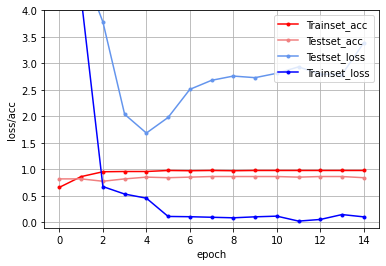

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
#plt.ylim(-0.1, 2)
plt.ylim(-0.1, 4)
plt.plot(x_len, acc, marker='.', c="red", label='Trainset_acc')
plt.plot(x_len, val_acc, marker='.', c="lightcoral", label='Testset_acc')
plt.plot(x_len, y_vloss, marker='.', c="cornflowerblue", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()